In [9]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from itertools import chain
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error

In [3]:
# Preprocessing data and helpers
number = re.compile('[\d,]+')
def get_first_number(val):
    matched = number.match(str(val))
    if matched:
        return int(matched.group().replace(',', ''))
    else:
        return np.nan

def dict_map(dict_to_use):
    def mapper(val):
        if val in dict_to_use:
            return dict_to_use[val]
        else:
            return np.nan

    return mapper

def split_list(list_str):
    return np.core.defchararray.split(list_str, sep='; ')

def userlist_to_cols(col):
    list_elems = col.astype(np.str).apply(split_list)
    categories = set(chain.from_iterable(list_elems.values))
    categories.discard('nan')
    categories = pd.Series(list(categories))
    
    def category_to_cols(category):
        return list_elems.map(lambda user_resp: category in user_resp)\
                         .rename('%s_%s' % (col.name, category))\
                         .astype('int8')
    
    new_cols = categories.map(category_to_cols)
    return pd.concat(new_cols.values, axis=1)

listvals = [
    'self_identification',
    'tech_do',
    'tech_want',
    'dev_environment',
    'education',
    'new_job_value',
    'how_to_improve_interview_process',
    'developer_challenges',
    'why_stack_overflow',
]

number_parses = [
    'company_size_range',
    'team_size_range',
    'women_on_team',
    'hobby',
    'rep_range',
    'interview_likelihood',
]

to_drop = [
    'age_range',
    'experience_range',
    'salary_range',
]

satisfaction_strs = {
    'I love my job': 10,
    'I\'m somewhat satisfied with my job': 7.5,
    'I\'m neither satisfied nor dissatisfied with my job': 5,
    'I\'m somewhat dissatisfied with my job': 2.5,
    'I hate my job': 0,
}

agree_strs = {
    'Agree completely': 5,
    'Agree somewhat': 4,
    'Neutral': 3,
    'Disagree somewhat': 2,
    'Disagree completely': 1,
}

important_strs = {
    'This is very important': 3,
    'This is somewhat important': 2,
    'I don\'t care about this': 1,
}

In [4]:
# 2016 preproc
data = pd.read_csv('data/2016.csv')
data['job_satisfaction'] = data['job_satisfaction']\
                                    .map(satisfaction_strs).astype('float')
data = data[data['job_satisfaction'].notnull()]

data['gender_M'] = (data['gender'] == 'Male').astype('int8')
data['gender_F'] = (data['gender'] == 'Female').astype('int8')
to_drop.append('gender')

to_drop.extend(listvals)
for index in listvals:
    data = pd.concat([data, userlist_to_cols(data[index])], axis=1)

data[number_parses] = data[number_parses].applymap(get_first_number).astype('float')

agree_keys = [index for index in data if 'agree_' in index]
data[agree_keys] = data[agree_keys].applymap(dict_map(agree_strs))

important_keys = [index for index in data if 'important_' in index]
data[important_keys] = data[important_keys].applymap(dict_map(important_strs))

data.drop(to_drop, axis=1, inplace=True)
data = pd.get_dummies(data)

print ('Columns with NaNs:')
for key in data:
    if data[key].isnull().any():
        print (key)
data.fillna(data.mean(), inplace=True)
print ('Filling with mean of column')

Columns with NaNs:
age_midpoint
experience_midpoint
salary_midpoint
big_mac_index
programming_ability
company_size_range
team_size_range
women_on_team
hobby
rep_range
interview_likelihood
agree_tech
agree_notice
agree_problemsolving
agree_diversity
agree_adblocker
agree_alcohol
agree_loveboss
agree_nightcode
agree_legacy
agree_mars
important_variety
important_control
important_sameend
important_newtech
important_buildnew
important_buildexisting
important_promotion
important_companymission
important_wfh
important_ownoffice
Filling with mean of column


In [5]:
data = data.drop(['Unnamed: 0'], axis=1)

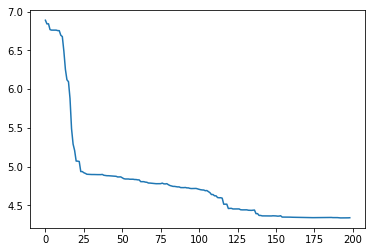

In [23]:
pca = PCA()
x_pca = pca.fit_transform(data.drop("job_satisfaction",1))

x_train, x_test, y_train, y_test = train_test_split(x_pca, data.job_satisfaction, test_size=0.30, random_state=43)

mse_rid = []
model = RidgeCV(alphas=[0.0001, 0.00021, 0.3333, 0.5, .00001, 0.59, 1, 5, 100, 1000, 10000, 99999, 100000])
for i in range(1,200):
    fit = model.fit(x_train[:,:i], y_train)
    x_sub = x_test[:,:i]
    lin_incpt_pred = fit.predict(x_sub)
    mse_rid.append(mean_squared_error(y_test, lin_incpt_pred))
plt.plot(mse_rid)

In [39]:
num_feats = 160
x_train, x_test, y_train, y_test = train_test_split(x_pca, data.job_satisfaction, test_size=0.30, random_state=43)
fit = model.fit(x_train[:,:num_feats], y_train)
pred = fit.predict(x_test[:,:num_feats])
print(mean_squared_error(y_test, pred))

4.34745979649


## XGB

## StackNet<br>
From https://github.com/kaz-Anova/StackNet 

In [46]:
x_train, x_test, y_train, y_test = train_test_split(data.drop("job_satisfaction",1), data.job_satisfaction, test_size=0.30, random_state=43)
train_new = pd.concat([y_train, x_train], 1)
test_new = pd.concat([y_test, x_test], 1)
test_new.head()
train_new.to_csv("data/trainSN_2016.csv", index = False)
test_new.to_csv("data/testSN_2016.csv", index = False)

In [ ]:
# data contains a DataFrame with no NaNs, all numbers.
# We're trying to predict the "job_satisfaction" column.